# 0) Resumo

1.  Importa dados

* data[ind][lei] =  dados originais em modificacao
* data2[ind][lei] = dados com filtro butterworth 20hz

2.  Segmenta dados
* data4[ind][lei][classe] = divisao com comprimento fixo 5 janelas base no trigger
* data5[ind][lei][classe] = divisao com comprimento fixo 5 janelas com ""centralizacao""
* x[id] = (0 a 3121) janelas capturadas
* z[id] = (0 a 13) classe atribuida a x[id]
* **y**[id] = (0 a 6) classes de movimentos.


# 1) Importar dados GITHUB

● Importa dados diretamente dos arquivos CSV originais (não tratados). (**github**)

In [0]:
import pandas as pd
import numpy as np
url = "https://raw.githubusercontent.com/pinojoke/Gestures_InertialSensors_EAAI/master/"
subjects = list(range(20))
mesurements = list(range(10))
data = []
for s in subjects:
  data.append([])
  for m in mesurements:
    filename = "subject"+str(s+1)+"_measurement"+str(m+1)+".csv"
    #print(filename)
    data[s].append(
        np.array(
            pd.read_csv(url+filename, header=None, encoding='utf8')))
print('Ok')

Ok


# 1.3 Extratores de características
Não usados por enquanto.

In [0]:
def getiavfeat(x, winsize=None, wininc=None, datawin=None):
  if winsize==None:
    winsize = x.shape[0]
  if wininc==None:
    wininc = winsize
  if datawin ==None:
    datawin = np.ones((winsize,1))
  datasize = x.shape[0]
  Nsignals = x.shape[1]
  numwin = floor((datasize-winsize)/wininc)+1
  feat = np.zeros((numwin,Nsignals))
  st = 0
  en = winsize
  for i in range(numwin):
    curwin = np.multiply(x[st:en,:],np.matlib.repmat(datawin,1,Nsignals))
    feat[i,:] = np.sum(np.absolute(curwin), axis=0)
    st += wininc
    en += wininc
  return feat

In [0]:
def getmavfeat(x, winsize=None, wininc=None, datawin=None):
  if winsize==None:
    winsize = x.shape[0]
  if wininc==None:
    wininc = winsize
  if datawin ==None:
    datawin = np.ones((winsize,1))
  datasize = x.shape[0]
  Nsignals = x.shape[1]
  numwin = floor((datasize-winsize)/wininc)+1
  feat = np.zeros((numwin,Nsignals))
  st = 0
  en = winsize
  for i in range(numwin):
    curwin = np.multiply(x[st:en,:],np.matlib.repmat(datawin,1,Nsignals))
    feat[i,:] = np.mean(np.absolute(curwin), axis=0)
    st += wininc
    en += wininc
  
  return feat

In [0]:
def getrmsfeat(x, winsize=None, wininc=None, datawin=None):
  if winsize==None:
    winsize = x.shape[0]
  if wininc==None:
    wininc = winsize
  if datawin ==None:
    datawin = np.ones((winsize,1))
  datasize = x.shape[0]
  Nsignals = x.shape[1]
  numwin = floor((datasize-winsize)/wininc)+1
  feat = np.zeros((numwin,Nsignals))
  st = 0
  en = winsize
  for i in range(numwin):
    curwin = np.multiply(x[st:en,:],np.matlib.repmat(datawin,1,Nsignals))
    feat[i,:] = np.sqrt(np.mean(np.square(curwin), axis=0))
    st += wininc
    en += wininc
  
  return feat

In [0]:
# valores diferentes na funcao DIFF
def getsscfeat(x, deadzone, winsize=None, wininc=None, datawin=None):
  if winsize==None:
    winsize = x.shape[0]
  if wininc==None:
    wininc = winsize
  if datawin ==None:
    datawin = np.ones((winsize,1))
  x = np.concatenate((np.zeros((1,x.shape[1])),np.diff(x,axis=0)),axis=0)
  datasize = x.shape[0]
  Nsignals = x.shape[1]
  numwin = floor((datasize-winsize)/wininc)+1
  feat = np.zeros((numwin,Nsignals))
  st = 0
  en = winsize
  for i in range(numwin):
    y = np.multiply(x[st:en,:],np.matlib.repmat(datawin,1,Nsignals))
    y = (y>deadzone).astype(np.float32)-(y<-deadzone).astype(np.float32)
    a=1
    b = np.transpose(np.exp(-(np.array(list(range(1,winsize//2))))))
    z = signal.lfilter(b, a, y, axis=0)
    z = (z>0).astype(np.float32)-(z<-0).astype(np.float32)
    dz = np.diff(z)
    feat[i,:] = np.sum(np.absolute(dz)==2, axis=0)
    st += wininc
    en += wininc
  
  return feat
x = data[2][0]
#feat = getsscfeat(x,50,150,75)
#feat

In [0]:
#codigo quse identico ao SSC (excecao 1a linha comentada abaixo)
def getzcfeat(x, deadzone, winsize=None, wininc=None, datawin=None):
  if winsize==None:
    winsize = x.shape[0]
  if wininc==None:
    wininc = winsize
  if datawin ==None:
    datawin = np.ones((winsize,1))
  #x = np.concatenate((np.zeros((1,x.shape[1])),np.diff(x,axis=0)),axis=0)
  datasize = x.shape[0]
  Nsignals = x.shape[1]
  numwin = floor((datasize-winsize)/wininc)+1
  feat = np.zeros((numwin,Nsignals))
  st = 0
  en = winsize
  for i in range(numwin):
    y = np.multiply(x[st:en,:],np.matlib.repmat(datawin,1,Nsignals))
    y = (y>deadzone).astype(np.float32)-(y<-deadzone).astype(np.float32)
    a=1
    b = np.transpose(np.exp(-(np.array(list(range(1,winsize//2))))))
    z = signal.lfilter(b, a, y, axis=0)
    z = (z>0).astype(np.float32)-(z<-0).astype(np.float32)
    dz = np.diff(z, axis=0)
    feat[i,:] = np.sum(np.absolute(dz)==2, axis=0)
    #dz = diff(z);                       #original matlab
    #feat(i,:) = (sum(abs(dz)==2));      #original matlab
    st += wininc
    en += wininc
  
  return feat
x = data[2][0]
#feat = getzcfeat(x,50,150,75)
#print(feat.shape, '\n', feat)

In [0]:
# comparacao valores sao proximos do matlab, mas nao sao identicas.
# possivel causa na funcao DIFF
import numpy.matlib
def getwlfeat(x, winsize=None, wininc=None, datawin=None):
  if winsize==None:
    winsize = x.shape[0]
  if wininc==None:
    wininc = winsize
  if datawin==None:
    datawin = np.ones((winsize,1))
  datasize = x.shape[0]
  Nsignals = x.shape[1]
  numwin = ((datasize-winsize)//wininc)+1
  feat = np.zeros((numwin,Nsignals))
  st = 0
  en = winsize
  for i in range(numwin):
    curwin = np.multiply(x[st:en,:],np.matlib.repmat(datawin,1,Nsignals))
    #feat[i,:] = np.sum(np.absolute(np.diff(curwin, axis=0)), axis=0) #iav
    feat[i,:] = np.sum(np.absolute(np.diff(curwin, n=2, axis=0)), axis=0)
    #feat[i,:] = np.sum(np.absolute(np.diff(np.diff(curwin, axis=0), axis=0)), axis=0)
    #feat(i,:) = sum(abs(diff(curwin,2))); #matlab original
    st += wininc
    en += wininc
  return feat

x=data[2][0]
#x.shape[0]
#x.shape[1]
#len(x)
feat = getwlfeat(x,150,74)
#feat
#print(feat.shape, x.shape)

# 1.4 Segmentação e Visualização

● Salvar cada grupo de janela em um arquivo separado. (Classe 0 1 2 3 4 5 6)
• 

In [0]:
# Funcao captura de dados a partir do index da janela
def get_janela(index, janela=None, ind=None, lei=None):
  dados_janela = np.zeros((janela,10))
  for i in range(janela):
    dados_janela[i,:] = data[ind][lei][index+i,0:10]
  
  return dados_janela

#======================================================================
def get_5janelas(index, janela=None, ind=None, lei=None):
  dados_janela = np.zeros((janela*5,10))
  #dados_janela[i,:] = data[ind][lei][index+i,0:10]
  #dados_index_janela = np.zeros((janela,10))

  for i in range(janela*5):
    dados_janela[i,:] = data[ind][lei][index+i,0:10]
    #dados_janela = np.concatenate(( dados_index_janela, get_janela(i*passo+janela, janela, ind, lei) )) # Adiciona coluna tempo novamente

  sig=9
  tmp = dados_janela[90:110,sig]
  tmp2 = get_janela(index-10, janela, ind, lei)
  #print( np.mean(tmp2[:,9]), np.mean(tmp) )
  if (np.max(tmp)>300 or np.min(tmp)<250): 
    print('5Janela', ind, lei, index)
    if abs( np.mean(tmp2[:,9])-np.mean(tmp) )<25:
      dados_janela = get_5janelas(index-5, janela, ind, lei)
      
  return dados_janela

#======================================================================
# Funcao captura 5 janelas a partir do index
def get_5janela(index, janela=None, ind=None, lei=None):
  janela2 = janela*5
  dados_janela = np.zeros((janela2,10))
  for i in range(janela2):
    dados_janela[i,:] = data[ind][lei][index+i,0:10]
    
  # Confere se final da janela sobrepos
  #tmp = data[ind][lei][i*passo:i*passo+janela,sig]
  #tmp = dados_janela[100:110,sig]
  #if np.max(tmp)>300 or np.min(tmp)<250:
  #  print('a')
  #  dados_janela = get_5janela(index-10, janela, ind, lei)
  #else:
  return dados_janela

#======================================================================
''' 

indd = 2
leii = 0
indx = 1760

teste = get_5janelas(indx, 22, indd, leii) # 5 janelas com recursiva
teste2 = get_5janela(indx, 22, indd, leii) # 5 janelas
#dados_janela = np.zeros((janela,10))
#print( dados_janela) #, teste.shape,  )
print( teste.shape, teste2.shape )
plt.rcParams["figure.figsize"] = (10,5)    # largura / altura
plt.plot(teste)
plt.show()
plt.plot( teste2 )
#print( teste[100:110,:])
#''';

#Fim
print( 'Ok' )

Ok


# 2) Segmenta TODOS para data*X* [ind] [lei] [classes]

In [0]:
# Extrai cada classe para data4[ind][lei][classe]
# data5 = classes ajustadas centralizadas

contador2 = 0
sig = 9
data4 = []
data5 = [] # Contem dados SEGMENTADOS em 5 JANELAS RECURSIVA

# Confere todos INDIVIDUOS
for ind1 in range(0, 20):
  data4.append([]) #data4[0]
  data5.append([])

  for lei1 in range(0, 10):                             # Confere todas LEITURAS
    data4[ind1].append([]) #data[0][0]
    data5[ind1].append([])
    
    passo = 22
    total_leitura = data[ind1][lei1].shape[0]
    
    classe = 0
    ultimaclasse = 50
    conta5janela = 0
    
    data4[ind1][lei1].append([]) #data[0][0][0]
    data4[ind1][lei1][classe] = np.array([], dtype=np.int64).reshape(0,10)
    data5[ind1][lei1].append([])
    data5[ind1][lei1][classe] = np.array([], dtype=np.int64).reshape(0,10)
    
    # LOOP para cada amostra (cada linha coletada)
    for i in range( total_leitura//passo ):
      
      tmp = data[ind1][lei1][i*passo:i*passo+passo,sig]
      
      if classe == 12:
        #print(i,'Oi')
        break
        print('aaaaaaaaaa')
      
      if (np.max(tmp)>300 or np.min(tmp)<250):# or (conta5janela != 5 and conta5janela !=0):
        if not inclass:
          classe += 1
          data4[ind1][lei1].append([])
          data5[ind1][lei1].append([])
          # Captura janela anterior ao inicio do trigger
          #data4[ind1][lei1][classe] = get_janela( (i-1)*passo+passo, passo, ind1, lei1 )
          data4[ind1][lei1][classe] = get_5janela( (i-1)*passo+passo, passo, ind1, lei1 )
          data5[ind1][lei1][classe] = get_5janelas( (i-1)*passo+passo, passo, ind1, lei1 )
          conta5janela += 1
            
        # Captura janela da classe
        #data4[ind1][lei1][classe] = np.concatenate(( data4[ind1][lei1][classe], get_janela( i*passo, passo, ind1, lei1) ))
        
        #for conta5janela != 5 or conta5janela !=0)
        
        
        ultimaclasse = classe
        conta5janela +=1
        
        inclass = True
      else:
        inclass = False
        #print( classe, ultimaclasse, len( data4[ind1][lei1] ) )
        
        conta5janela = 0
        if ultimaclasse == classe:
          classe += 1
          data4[ind1][lei1].append([])
          data5[ind1][lei1].append([])
        
          data4[ind1][lei1][classe] = get_janela( i*passo+passo, passo, ind1, lei1 )
          data5[ind1][lei1][classe] = get_janela( i*passo+passo, passo, ind1, lei1 )
          
        data4[ind1][lei1][classe] = np.concatenate(( data4[ind1][lei1][classe], get_janela( i*passo, passo, ind1, lei1) ))
        data5[ind1][lei1][classe] = np.concatenate(( data5[ind1][lei1][classe], get_janela( i*passo, passo, ind1, lei1) ))
        #ultimaclasse = classe
        
        
      #fim for amostra
    #fim for leitura
    if (len(data4[ind1][lei1]) != 13):
      print( 'Ind:', ind1, 'Lei:', lei1 , 'Classes:', len(data4[ind1][lei1]))
  #fim for individuo
  



'''
for grap in range(0,2,2):                        # 0a20, de 2 em 2
  plt.clf()

'''
ind1 = 5
lei1 = 1
print( len( data4[ind1][lei1] ), contador2, end=' ' )
#print( data4[ind1][lei1][0].shape, data4[ind1][lei1][1].shape), data4[ind1][lei1][2].shape );
#for i in range(14):
#  print(i, data4[1][6][i].shape)
print( ' End' )


5Janela 0 2 594
5Janela 0 2 589
5Janela 1 0 242
5Janela 1 0 237
5Janela 1 0 440
5Janela 1 0 435
5Janela 1 0 430
5Janela 1 0 425
5Janela 1 1 440
5Janela 1 2 242
5Janela 1 2 440
5Janela 1 2 638
5Janela 1 5 484
5Janela 1 5 479
5Janela 1 7 308
5Janela 1 7 303
5Janela 1 7 506
5Janela 1 7 501
5Janela 1 7 496
5Janela 1 7 594
5Janela 1 9 374
5Janela 4 1 1144
5Janela 4 1 1139
5Janela 4 1 1134
5Janela 4 1 1129
5Janela 4 1 1124
5Janela 4 1 1119
5Janela 4 1 1114
5Janela 8 2 1364
5Janela 8 2 1359
5Janela 8 2 1354
5Janela 8 7 1562
5Janela 8 7 1557
5Janela 8 7 1552
5Janela 8 7 1547
5Janela 8 7 1542
5Janela 11 3 1474
5Janela 11 3 1469
5Janela 11 3 1464
5Janela 11 3 1459
5Janela 11 3 1454
5Janela 11 3 1449
5Janela 11 3 1444
5Janela 11 5 1408
5Janela 11 5 1403
5Janela 11 5 1398
5Janela 11 5 1393
5Janela 12 4 1694
5Janela 12 4 1689
5Janela 12 4 1684
5Janela 12 4 1679
5Janela 12 4 1674
5Janela 12 4 1669
5Janela 13 0 1320
5Janela 13 0 1315
5Janela 13 0 1310
5Janela 13 0 1305
5Janela 13 0 1300
5Janela 13 0 

# Salva cada CLASSE em arquivo


In [0]:
# Salva data5 em arquivos.

import os
import math
import matplotlib
import matplotlib.pyplot as plt

dir_files = 'a'
dir_files2 = 'b'
a=0
b=0
x = []
#x.append([])
y = []
#y.append([])
#os.makedirs(dir_files, exist_ok=True) #os.mkdir('a')
os.makedirs(dir_files2, exist_ok=True) #os.mkdir('b')

# SALVA todos dados da variavel DATA4
for ind1 in range(0,20):
  for lei1 in range(10):
    #for clas1 in range( len(data4[ind1][lei1]) ):
    #  np.savetxt(str(dir_files)+'/s'+str(ind1)+'m'+str(lei1)+'c'+str(clas1)+'.txt', data4[ind1][lei1][clas1], delimiter=',',fmt='%10.2f')
      #print( 'c'+str(a1), '> ', data4[ind1][lei1][a1].shape[0], 'x', data4[ind1][lei1][a1].shape[1] )
      #np.savetxt(str(dir_files)+'/s'+str(ind1).zfill(2)+'m'+str(lei1).zfill(2)+'c'+str(clas1).zfill(2)+'.txt', data4[ind1][lei1][clas1], delimiter=',',fmt='%10.2f')
      #os.remove('s'+str(ind1)+'m'+str(lei1)+'c'+str(a1)+'.txt')
    #print(range( len(data5[ind1][lei1] ) ) )
    for clas1 in range( len(data5[ind1][lei1]) ):
      
      tmp = data5[ind1][lei1][clas1].shape[0]
      if tmp > 111:
        tmp2 = tmp/110
        for i in range( math.floor(tmp2) ):
          #b += 1
          x.append([])
          x[b] = data5[ind1][lei1][clas1][i*110:(i+1)*110,:]
          y.append([])
          y[b] = 0
          
          b += 1
          #np.savetxt(str(dir_files2)+'/s'+str(ind1)+'m'+str(lei1)+'c'+str(clas1)+'_'+str(i)+'.txt', data5[ind1][lei1][clas1][i*110:(i+1)*110,:], delimiter=',',fmt='%10.2f')
      elif tmp == 110:
        #b += 1
        x.append([])
        x[b] = data5[ind1][lei1][clas1]    #[i*110:(i+1)*110,:]
        y.append([])
        if clas1 % 2 == 0: #Par
          y[b] = 0
        else:              #Impar
          #y[b] = clas1
          if clas1 <= 1:
            y[b] = clas1
          elif clas1 == 3:
            y[b] = 2
          elif clas1 == 5:
            y[b] = 3
          elif clas1 == 7:
            y[b] = 4
          elif clas1 == 9:
            y[b] = 5
          elif clas1 == 11:
            y[b] = 6
          elif clas1 == 13:
            y[b] = 7
            print('-------------------------------------------------')
          
            #print(b)
            
        b += 1
        #np.savetxt(str(dir_files2)+'/s'+str(ind1)+'m'+str(lei1)+'c'+str(clas1)+'.txt', data5[ind1][lei1][clas1], delimiter=',',fmt='%10.2f')
      #elif tmp == 88:
      #  esticar
      else:
        #print('Ignorados:', ind1, lei1, clas1, 'Shape:', tmp)
        a += 1
    #Para cada leitura
    #print ( 'Ind: '+str(ind1)+' Lei: '+str(lei1)+'> ', b1 ,'-', data[ind1][lei1].shape[0], '=', b1-data[ind1][lei1].shape[0] )
      
        
  #Para cada Individuo
  #print ( 'Ind: '+str(ind1)+'> ', b1 ,'-', data[ind1][lei1].shape[0], '=', b1-data[ind1][lei1].shape[0] )

print( len(x) );
  
deee = 1
#===============================================================================
if deee == 0:

  plt.rcParams["figure.figsize"] = (15,5)   # largura / altura
  for aa in range(6):
    plt.subplot(2,6,aa+1)
    plt.plot( data4[4][1][aa+1] );
    plt.ylim([-50,700])  
  #plt.subplot(221)
  #plt.plot( data4[0][0][0] );


2695


In [0]:
# Plot Histograma teste
#''';
import matplotlib.pyplot as plt
#x=[]
#x.append([])
#x[1] = 1
#num = 0
#y=[]
#print(x[num], y[num], len(x), '\n', x[3120] )
#print( min(y), max(y), y[0] )
#print( min(y) )
#print(x[3120])
a0 = 0
a1 = 0
a2 = 0
a3 = 0
a4 = 0
a5 = 0
a6 = 0
a7 = 0
#yct=[]
for i in range(0, len(x) ):
  if y[i] == 0:
    a0 += 1
  if y[i] == 1:
    a1 += 1
  if y[i] == 2:
    a2 += 1
  if y[i] == 3:
    a3 += 1
  if y[i] == 4:
    a4 += 1
  if y[i] == 5:
    a5 += 1
  if y[i] == 6:
    a6 += 1
  if y[i] == 7:
    a7 += 1
  
  #for ii in range(0,7):
  #  if y[i] == ii:
  #    yct.append([])
  #    yct[ii] += 1

print( a0, a1, a2, a3, a4, a5, a6, a7)
print( y[0:20] )
#print( )
  
#plt.hist(y, bins=14)
#''';

1495 200 200 200 200 200 200 0
[0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0, 0, 0, 1, 0, 2, 0]


# 3) Classificadores

In [0]:
# Exemplo de RF tirado de:
# https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.08-Random-Forests.ipynb#scrollTo=Q647tymJ3qpf
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

3.0) k-fold

In [0]:
#https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [0]:
# Load the Diabetes dataset
columns = 'age sex bmi map tc ldl hdl tch ltg glu'.split() # Declare the columns names
diabetes = datasets.load_diabetes() # Call the diabetes dataset from sklearn
df = pd.DataFrame(diabetes.data, columns=columns) # load the dataset as a pandas data frame
yfff = diabetes.target # define the target variable (dependent variable) as yfff

In [0]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df, yfff, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#(353, 10) (353,)
#(89, 10) (89,)
print('# ', df.shape, yfff.shape, columns[0:2]);

(353, 10) (353,)
(89, 10) (89,)
#  (442, 10) (442,) ['age', 'sex']


In [0]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [0]:
predictions[0:5]
#array([ 205.68012533,   64.58785513,  175.12880278,  169.95993301, 128.92035866])

array([222.20970166, 127.11745725, 197.68055845, 207.05841893,
       146.50078489])

Text(0, 0.5, 'Predictions')

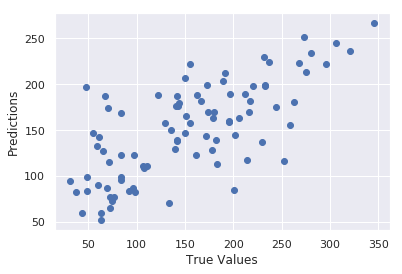

In [0]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [0]:
print('Score:', model.score(X_test, y_test) )
#Score: 0.485829586737

Score: 0.5073402065434711


In [0]:
from sklearn.model_selection import KFold # import KFold

Xaaa = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
yaaa = np.array([1, 2, 3, 4]) # Create another array
kf = KFold(n_splits=2) # Define the split - into 2 folds 
kf.get_n_splits(Xaaa) # returns the number of splitting iterations in the cross-validator
print(kf) 
#KFold(n_splits=2, random_state=None, shuffle=False)

KFold(n_splits=2, random_state=None, shuffle=False)


In [0]:
for train_index, test_index in kf.split(Xaaa):
  print('TRAIN:', train_index, 'TEST:', test_index)
  X_train, X_test = Xaaa[train_index], Xaaa[test_index]
  y_train, y_test = yaaa[train_index], yaaa[test_index]
  
#('TRAIN:', array([2, 3]), 'TEST:', array([0, 1]))
#('TRAIN:', array([0, 1]), 'TEST:', array([2, 3]))

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


# 3.1) KNN

In [0]:
# Adaptado de Hand written digits
# https://github.com/mohan-mj/Random-Forest-Classification/blob/master/Hand%20written%20digits.ipynb
# The digits dataset
#''';

import matplotlib.pyplot as plt
from sklearn import datasets, metrics
#from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#''';

In [0]:
# Converte LIST em ARRAY

xa = np.asarray(x)
ya = np.asarray(y)

p_samples = len(xa)
p_data = xa.reshape((p_samples, -1))

print( p_samples, xa.shape, p_data.shape, ya.shape)

2695 (2695, 110, 10) (2695, 1100) (2695,)


In [0]:
# ==============================================================================
# Create a classifier: a random forest classifier
# classifierpiol = RandomForestClassifier(n_estimators=30, criterion='entropy')
classifierKNN = KNeighborsClassifier(n_neighbors = 3)

# We learn the digits on the first half of the digits
# classifierpiol.fit(p_data[:p_samples // 10*7], ya[:p_samples // 10*7])
classifierKNN.fit(p_data[:p_samples // 10*7], ya[:p_samples // 10*7])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
# Now predict the value of the digit on the second half:
expected = ya[p_samples // 10*3:]
#predicted = classifierpiol.predict(p_data[p_samples // 10*3:])
predicted = classifierKNN.predict(p_data[p_samples // 10*3:])

In [0]:
#classifierpiol.score(p_data[p_samples // 10*3:], expected)
classifierKNN.score(p_data[p_samples // 10*3:], expected)

0.8776483050847458

In [0]:
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)
print( 'F1_score:',  metrics.f1_score(expected, predicted, average=None) )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print('Normalized: \n', cm)

Confusion matrix:
[[1072    0    0    0    0    0    0]
 [  20  115    0    1    0    0    0]
 [  11   29   89    5    2    0    0]
 [  55    0    0   81    0    0    0]
 [  24   14    0   33   65    0    0]
 [   2    4    0    0    0  127    3]
 [   3    0    4    0    1   20  108]]
F1_score: [0.94909252 0.77181208 0.77729258 0.6328125  0.6372549  0.8975265
 0.87449393]


Confusion matrix, without normalization
Normalized confusion matrix


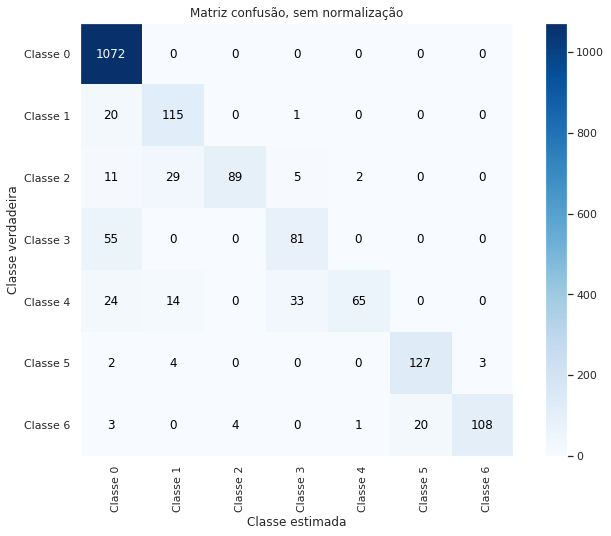

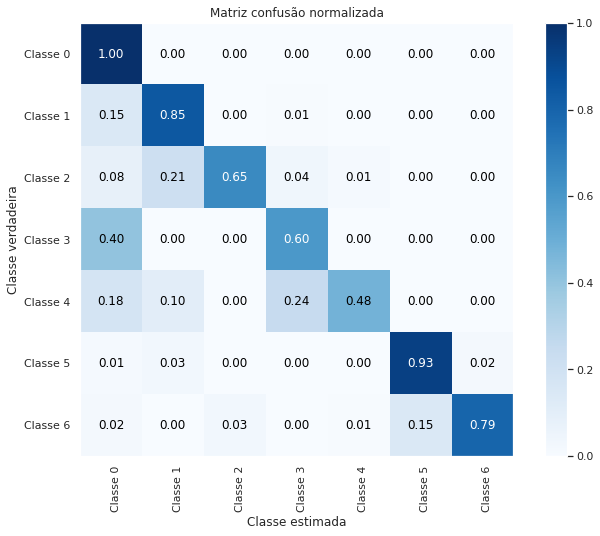

In [0]:
# Adaptado de:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array([ 'Classe 0', 'Classe 1', 'Classe 2', 'Classe 3',
                        'Classe 4',  'Classe 5', 'Classe 6', 'Classe 7'])
y_test = expected
y_pred = predicted

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Classe verdadeira',
           xlabel='Classe estimada')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.grid(None)
    fig.set_size_inches(10,10)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Matriz confusão, sem normalização')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Matriz confusão normalizada')


plt.show()

# Metricas
print()

In [0]:
import pandas as pd
print( p_data[:p_samples // 10*7].shape )
#'''

#feature_importances = pd.DataFrame(classifierpiol.feature_importances_).sort_values(by=0,ascending=False)

names = ya[0:7]
p_data[:p_samples // 10*7]

#print sorted(zip(map(lambda p_data[:p_samples // 10*7]: round(p_data[:p_samples // 10*7], 4), classifierpiol.feature_importances_), names), 
#             reverse=True)
#''';
#y_pred[0:10]

(1883, 1100)


array([[229., 254., 474., ..., 497., 282., 280.],
       [240., 253., 478., ..., 507., 282., 281.],
       [249., 266., 478., ..., 500., 283., 280.],
       ...,
       [194., 192., 455., ..., 500., 276., 278.],
       [248., 238., 468., ..., 499., 278., 274.],
       [246., 199., 479., ..., 494., 280., 279.]])